In [29]:
# Importing Libraries including NFLfastpy
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)

In [3]:
#Importing play-by-play data to dataframe
years = [2023]
pbp_df = nfl.import_pbp_data(years, downcast=True, cache=False)
wkly_df = nfl.import_weekly_data(years, downcast=True)
szn_df = nfl.import_seasonal_data(years)
ros_df = nfl.import_seasonal_rosters(years)

2023 done.
Downcasting floats.
Downcasting floats.


In [4]:
pbp_column_list = [column for column in nfl.see_pbp_cols()]
wkly_column_list = [column for column in nfl.see_weekly_cols()]

In [5]:
#array(['GAME_START', 'KICK_OFF', 'RUSH', 'PASS', 'PUNT', 'PENALTY',
#        'XP_KICK', 'TIMEOUT', 'FIELD_GOAL', 'SACK', 'END_QUARTER',
#        'INTERCEPTION', 'UNSPECIFIED', 'END_GAME',
#        'FUMBLE_RECOVERED_BY_OPPONENT', 'PAT2', 'COMMENT']

#cleaning up missing values and play types that are irrelevant

play_types = ['RUSH', 'PASS', 'PUNT', 'PENALTY','SACK','INTERCEPTION', 'FUMBLE_RECOVERED_BY_OPPONENT']
df = pbp_df[pbp_df['play_type_nfl'].isin(play_types)]

In [6]:
#investigating yards_gain == NaN values
plays = df[df["yards_gained"].isnull()]
plays = df[df["yards_gained"].isnull()]["desc"].tolist()
plays

['(13:04) (Shotgun) 7-G.Smith pass incomplete short left.\r\nPenalty on SEA-60-P.Haynes, Offensive Holding, offsetting, enforced at LA 42 - No Play.\r\nPenalty on LA-99-A.Donald, Roughing the Passer, offsetting.',
 '(:41) (No Huddle, Shotgun) 17-J.Allen scrambles right end to LV 11 for 15 yards (5-D.Deablo).\r\nPenalty on BUF-64-O.Torrence, Offensive Holding, offsetting, enforced at LV 26 - No Play.\r\nPenalty on LV-25-T.Moehrig, Unnecessary Roughness, offsetting.',
 '(3:47) (Shotgun) 63-E.Brown to DET 9 for -2 yards. FUMBLES, recovered by SEA-7-G.Smith at DET 11. 7-G.Smith pass incomplete short right to 14-D.Metcalf.\r\nPenalty on SEA-14-D.Metcalf, Face Mask, offsetting, enforced at DET 7 - No Play.\r\nPenalty on DET-31-K.Joseph, Defensive Pass Interference, offsetting.',
 '(3:32) 13-C.Reynolds left end to DET 36 for 3 yards (44-T.Andersen). ATL-44-T.Andersen was injured during the play. \r\nPenalty on DET-8-J.Reynolds, Offensive Holding, offsetting, enforced at DET 33 - No Play.\r\nP

In [7]:
#remove errenous plays (e.g. 30 plays with NaN as yards gained)
df = df[df["down"].notnull()]
df = df[df["yards_gained"].notnull()]

In [8]:
df.duplicated().sum()

0

In [9]:
#checking play types in current df
df['play_type_nfl'].unique()

array(['RUSH', 'PASS', 'PUNT', 'PENALTY', 'SACK', 'INTERCEPTION',
       'FUMBLE_RECOVERED_BY_OPPONENT'], dtype=object)

In [10]:
df["play_type"].unique()

array(['run', 'pass', 'punt', 'no_play', 'qb_kneel', 'qb_spike'],
      dtype=object)

In [11]:
#data types of features
df.dtypes

play_id                                 float32
game_id                                  object
old_game_id                              object
home_team                                object
away_team                                object
season_type                              object
week                                      int32
posteam                                  object
posteam_type                             object
defteam                                  object
side_of_field                            object
yardline_100                            float32
game_date                                object
quarter_seconds_remaining               float32
half_seconds_remaining                  float32
game_seconds_remaining                  float32
game_half                                object
quarter_end                             float32
drive                                   float32
sp                                      float32
qtr                                     

In [52]:
#casting downs, yard line, yards to go, etc. to integers from floats
df = df.astype({"down": 'int',
                'first_down': 'int',
                "yardline_100": 'int',
                "yards_gained": 'int',
                "ydstogo" : 'int',
                "third_down_converted": 'int'
                })

In [59]:
#separated into downed dfs for down scenarios analysis
down_df = df[['game_id', 'home_team', 'away_team', 'quarter_seconds_remaining', 'week', 'posteam_type','posteam', 'defteam', 'down', 'first_down', 'yardline_100', 'ydstogo', 'play_type', 'play_type_nfl']]
down_df = down_df[down_df["play_type_nfl"] != "PUNT"]

In [60]:
#creating efficiencies by down
first_down_off = pd.DataFrame(down_df[down_df["down"] == 1].groupby("posteam")["first_down"].sum()/down_df[down_df["down"] == 1].groupby("posteam")["first_down"].count()).reset_index().rename(columns={"posteam": "Team", "first_down": "1st_off_eff"})
first_down_def = pd.DataFrame(1 - down_df[down_df["down"] == 1].groupby("defteam")["first_down"].sum()/down_df[down_df["down"] == 1].groupby("defteam")["first_down"].count()).reset_index().rename(columns={"defteam": "Team", "first_down": "1st_def_eff"})
second_down_off = pd.DataFrame(down_df[down_df["down"] == 2].groupby("posteam")["first_down"].sum()/down_df[down_df["down"] == 2].groupby("posteam")["first_down"].count()).reset_index().rename(columns={"posteam": "Team", "first_down": "2nd_off_eff"})
second_down_def = pd.DataFrame(1 - down_df[down_df["down"] == 2].groupby("defteam")["first_down"].sum()/down_df[down_df["down"] == 2].groupby("defteam")["first_down"].count()).reset_index().rename(columns={"defteam": "Team", "first_down": "2nd_def_eff"})
third_down_off = pd.DataFrame(down_df[down_df["down"] == 3].groupby("posteam")["first_down"].sum()/down_df[down_df["down"] == 3].groupby("posteam")["first_down"].count()).reset_index().rename(columns={"posteam": "Team", "first_down": "3rd_off_eff"})
third_down_def = pd.DataFrame(1 - down_df[down_df["down"] == 3].groupby("defteam")["first_down"].sum()/down_df[down_df["down"] == 3].groupby("defteam")["first_down"].count()).reset_index().rename(columns={"defteam": "Team", "first_down": "3rd_def_eff"})
fourth_down_off = pd.DataFrame(down_df[down_df["down"] == 4].groupby("posteam")["first_down"].sum()/down_df[down_df["down"] == 4].groupby("posteam")["first_down"].count()).reset_index().rename(columns={"posteam": "Team", "first_down": "4th_off_eff"})
fourth_down_def = pd.DataFrame(1 - down_df[down_df["down"] == 4].groupby("defteam")["first_down"].sum()/down_df[down_df["down"] == 4].groupby("defteam")["first_down"].count()).reset_index().rename(columns={"defteam": "Team", "first_down": "4th_def_eff"})

In [61]:
#Offensive and defensive efficiency per team by down
down_effs_df = first_down_off.merge(first_down_def, on="Team")\
                                .merge(second_down_off, on="Team")\
                                    .merge(second_down_def, on="Team")\
                                        .merge(third_down_off, on="Team")\
                                            .merge(third_down_def, on="Team")\
                                                .merge(fourth_down_off, on="Team")\
                                                    .merge(fourth_down_def, on="Team")
down_effs_df

,Team,1st_off_eff,1st_def_eff,2nd_off_eff,2nd_def_eff,3rd_off_eff,3rd_def_eff,4th_off_eff,4th_def_eff
0,ARI,0.204918,0.786432,0.269784,0.619048,0.380952,0.544944,0.310345,0.571429
1,ATL,0.180693,0.848168,0.342193,0.654362,0.405263,0.648352,0.411765,0.562500
2,BAL,0.197995,0.834225,0.363333,0.735593,0.437500,0.629108,0.500000,0.666667
3,BUF,0.221951,0.773684,0.353535,0.728625,0.475410,0.609375,0.500000,0.450000
4,CAR,0.155263,0.793296,0.250847,0.655678,0.366071,0.638889,0.472222,0.200000
5,CHI,0.184896,0.817927,0.295918,0.709091,0.424084,0.556150,0.500000,0.608696
6,CIN,0.213568,0.719178,0.343434,0.679868,0.354167,0.585492,0.473684,0.642857
7,CLE,0.143204,0.824926,0.312121,0.775281,0.336406,0.704663,0.518519,0.500000
8,DAL,0.209639,0.799443,0.332237,0.739300,0.512563,0.634921,0.473684,0.517241
9,DEN,0.214470,0.796729,0.255245,0.600000,0.391960,0.646739,0.555556,0.558824


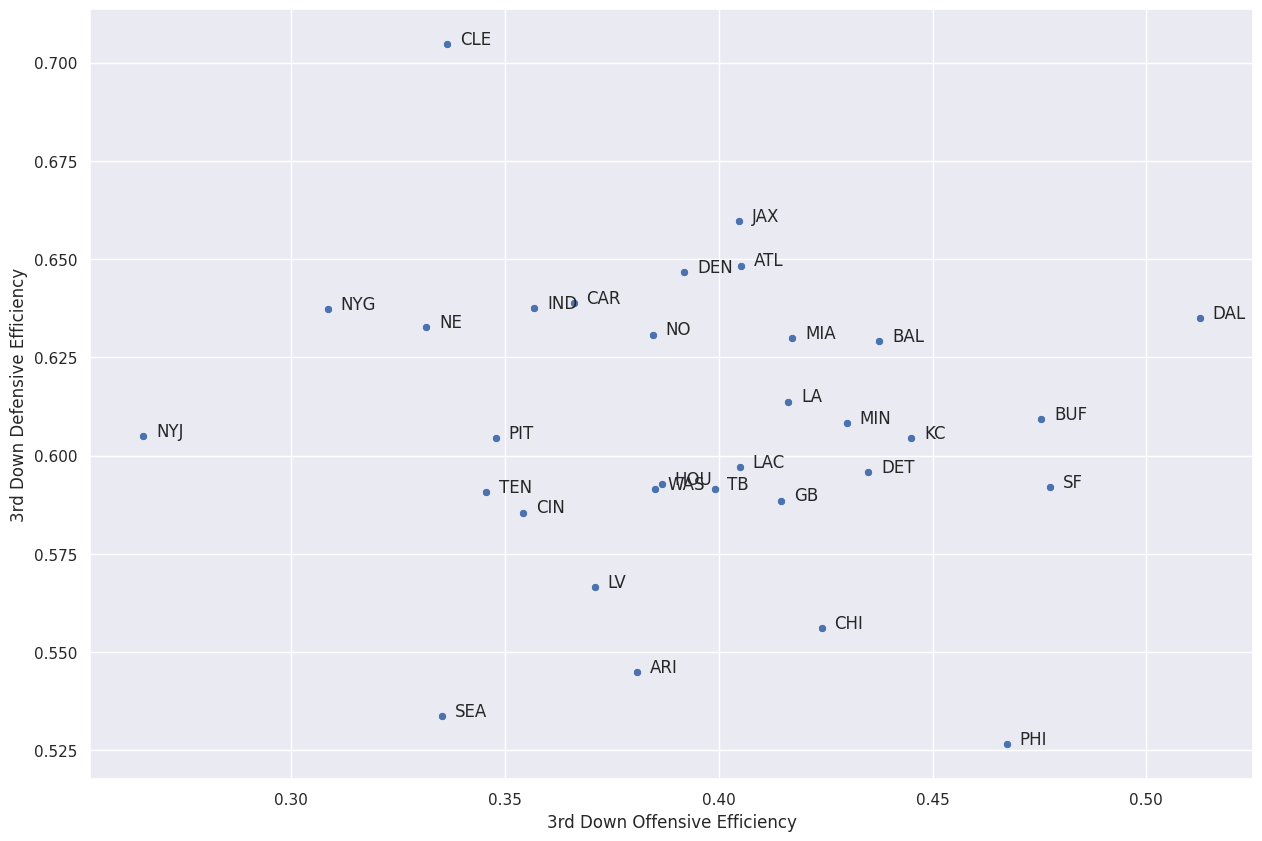

In [66]:
sns.scatterplot(data=down_effs_df,x="3rd_off_eff", y="3rd_def_eff")
plt.xlabel("3rd Down Offensive Efficiency")
plt.ylabel("3rd Down Defensive Efficiency")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.003, point['y'], str(point['val']))


label_point(down_effs_df["3rd_off_eff"], down_effs_df["3rd_def_eff"], down_effs_df["Team"], plt.gca())
rcParams['figure.figsize'] = (15, 10)
plt.show()

In [95]:
#DAL vs BUF
home_team = "BUF"
away_team = "DAL"



home_df = down_df[down_df["home_team"] == home_team]
away_df = down_df[down_df["away_team"] == away_team]
df = pd.concat([home_df, away_df])

offense = pd.DataFrame(df[df["down"] == 3].groupby("posteam")["first_down"].sum()/df[df["down"] == 3].groupby("posteam")["first_down"].count()).reset_index().rename(columns={"posteam": "Team", "first_down": "3rd_off"})
defense = pd.DataFrame(1 - df[df["down"] == 3].groupby("defteam")["first_down"].sum()/df[df["down"] == 3].groupby("defteam")["first_down"].count()).reset_index().rename(columns={"defteam": "Team", "first_down": "3rd_def"})

match_up_df = pd.DataFrame({"Team": [home_team, away_team]}).merge(offense, on="Team").merge(defense, on="Team")
match_up_df

,Team,3rd_off,3rd_def
0,BUF,0.470588,0.610619
1,DAL,0.478261,0.617021
